In [1]:
import sys
sys.path.append('../src')

In [2]:
import matplotlib.pyplot as plt
import os
import shutil
import random

from clahe import run_clahe
from PIL import Image

# Dataset Preparation
Download dataset from https://www.kaggle.com/tawsifurrahman/covid19-radiography-database#

In [ ]:
data_dir = '../data/COVID-19 Radiography Database'

In [5]:
# view the datasets downloaded
print(os.listdir(data_dir))

['COVID-19', 'NORMAL', 'README.md.txt', 'Viral Pneumonia']


In [7]:
# delete viral pneumonia since we are not interested on it
shutil.rmtree(os.path.join(data_dir, 'Viral Pneumonia'))

In [8]:
print(open(os.path.join(data_dir, 'README.md.txt')).read())

*****COVID-19 CHEST X-RAY DATABASE


We have created a database of chest X-ray images for COVID-19 positive cases along with Normal and Viral Pneumonia images. All the X-ray images will be released as soon as possible in Kaggle repository. In our current realease, there are 1143 COVID-19 positive images, 1341 normal images and 1345 viral pneuomonia images. We will continue to update this database as soon as we have new x-ray images for COVID-19 pneumonia patients.  


**COVID-19 data:
-----------------------
COVID data are collected from different publicly accessible dataset, online sources and published papers.
-400 CXR images from another Github source[1].
-183 CXR images from a Germany medical school[2].
-560 CXR image from SIRM, Github, Kaggle & Tweeter[3,4,5]

***Normal and Viral Pneumonia images:
---------------------------------------- 
Normal and Viral Pneumonia data are collected from  the Chest X-Ray Images (pneumonia) database [6]

**Reference:
[1]https://github.com/armiro/C

In [9]:
# resize all images
target_size = (299, 299)
for d in os.listdir(data_dir):
    if os.path.isdir(d):
        for img in os.listdir(os.path.join(data_dir, d)):
            im = Image.open(os.path.join(data_dir, d, img))
            im = im.resize(target_size)
            im.save(os.path.join(data_dir, d, img))

NotADirectoryError: [WinError 267] The directory name is invalid: '../data/COVID-19 Radiography Database\\README.md.txt'

# Image Enhancement using CLAHE
The Contrast Limited Adaptive Histogram Equalization (CLAHE) method is a histogram-based method used to improve contrast in images. This technique computes the histogram for the region around each pixel in the image, improving the local contrast and enhancing the edges in each region. Since AHE can overamplify noise in the image, CLAHE prevents this by limiting the amplification.

In [8]:
%%timeit
img_path = os.path.join(data_dir, 'COVID-19', 'COVID-19 (1).png')
equalized = run_clahe(img_path)

43.6 s ± 2.43 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


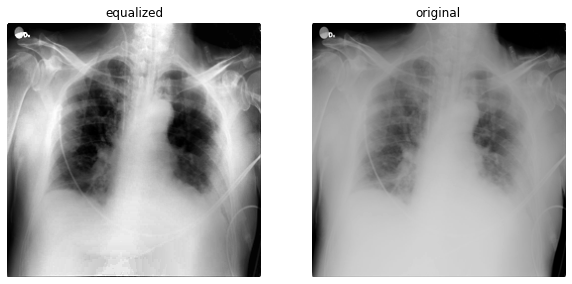

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(equalized, cmap='gray')
axs[0].set_title('equalized')
axs[0].axis('off')
axs[1].imshow(Image.open(img_path), cmap='gray')
axs[1].set_title('original')
axs[1].axis('off')
plt.show()

In [1]:
%%writefile parallel_clahe.py
import os
import sys

sys.path.append('../src')

from clahe import run_clahe
from PIL import Image
from multiprocessing import Pool

data_dir = '../data/COVID-19 Radiography Database'
output_dir = '../data/clahe_applied/'


def apply_clahe(img_path):
    equalized = run_clahe(img_path)
    im = Image.fromarray(equalized)
    dirs = [output_dir] + os.path.normpath(img_path).split(os.sep)[-2:]
    output_path = os.path.join(*dirs)
    im.save(output_path)


if __name__ == '__main__':
    print(os.cpu_count())
    all_paths = [os.path.join(data_dir, 'COVID-19', x) for x in os.listdir(os.path.join(data_dir, 'COVID-19'))] + [
        os.path.join(data_dir, 'NORMAL', x) for x in os.listdir(os.path.join(data_dir, 'NORMAL'))]
    with Pool() as pool:
        pool.map(apply_clahe, all_paths)

Overwriting parallel_clahe.py


In [52]:
output_dir = '../data/clahe_applied/'
os.makedirs(os.path.join(output_dir, 'COVID-19'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'NORMAL'), exist_ok=True)

In [55]:
# apply clahe to all image, this will take a long time to run
# not recommended to run from interactive notebook because it breaks multiprocessing
# ran it on google cloud compute instance

# !python parallel_clahe.py

^C


In [ ]:
data_dir = output_dir

# Dealing Class Imbalance

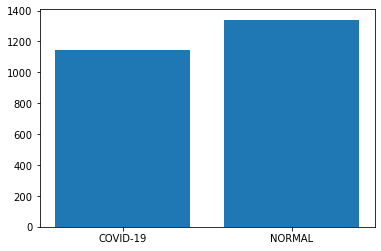

ratio:  0.8523489932885906


In [10]:
# visualize class balance
classes = ['COVID-19', 'NORMAL',]
count = [len(os.listdir(os.path.join(data_dir, x))) for x in classes]
plt.figure()
plt.bar(classes, count)
plt.show()
print('ratio: ', count[0]/count[1])

From figure above, we can observe that the ratio of dataset is slightly imbalanced. We solve this by randomly flipping images from the minor class

In [16]:
minor_class = classes[0]
scale = 0.02

for img_path in random.sample(os.listdir(os.path.join(data_dir, minor_class)), max(count) - min(count)):
    im = Image.open(os.path.join(data_dir, minor_class, img_path))
    width, height = im.size
    
    flipped = im.transpose(Image.FLIP_LEFT_RIGHT)

    flipped.save(os.path.join(data_dir, minor_class, 'flipped_' + img_path))

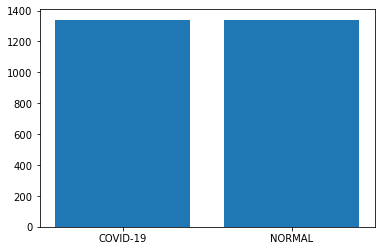

ratio:  1.0


In [17]:
# visualize class balance again
count = [len(os.listdir(os.path.join(data_dir, x))) for x in classes]
plt.figure()
plt.bar(classes, count)
plt.show()
print('ratio: ', count[0]/count[1])

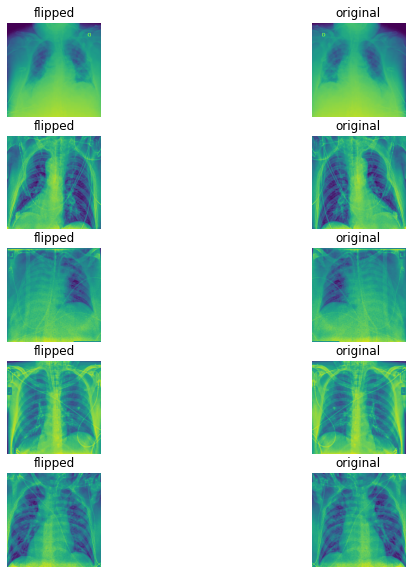

In [22]:
# look at some of the flipped images

fig, axs = plt.subplots(5, 2, figsize=(10, 10))
i = 0
for img_path in os.listdir(os.path.join(data_dir, minor_class)):
    if i >= 5:
        break
    if img_path.startswith('flipped_'):
        axs[i][0].imshow(Image.open(os.path.join(data_dir, minor_class, img_path)))
        axs[i][0].set_title('flipped')
        axs[i][0].axis('off')
        unflipped_img_path = '_'.join(img_path.split('_')[1:])
        axs[i][1].imshow(Image.open(os.path.join(data_dir, minor_class, unflipped_img_path)))
        axs[i][1].set_title('original')
        axs[i][1].axis('off')
        i += 1

plt.show()